In [ ]:

import pandas as pd
from google.colab import files
import io

uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

df.rename(columns={'SystemCodeNumber': 'Location_ID', 'VehicleType': 'Vehicle_Type',
                   'TrafficConditionsNearby': 'Traffic', 'LastUpdatedDate': 'Date',
                   'LastUpdatedTime': 'Time'}, inplace=True)

print("Columns:", df.columns.tolist())
print("Unique Parking Lots:", df['Location_ID'].nunique())
print("Vehicle Types:", df['Vehicle_Type'].unique())

Saving dataset.csv to dataset (3).csv
Columns: ['ID', 'Location_ID', 'Capacity', 'Latitude', 'Longitude', 'Occupancy', 'Vehicle_Type', 'TrafficConditionNearby', 'QueueLength', 'IsSpecialDay', 'Date', 'Time']
Unique Parking Lots: 14
Vehicle Types: ['car' 'bike' 'truck' 'cycle']


In [ ]:
base_price = 10
alpha = 2

linear_prices = [base_price]

for i in range(1, len(lot_df)):
    occ = lot_df.iloc[i]['Occupancy']
    cap = lot_df.iloc[i]['Capacity']
    prev_price = linear_prices[-1]
    new_price = prev_price + alpha * (occ / cap)
    new_price = max(5, min(20, new_price))
    linear_prices.append(round(new_price, 2))

lot_df['Linear_Price'] = linear_prices

In [ ]:

alpha = 1
beta = 0.5
gamma = 0.7
delta = 2
epsilon = {'car': 1, 'bike': 0.5, 'truck': 1.5, 'cycle': 0.75}
lamda = 0.3

lot_df['Vehicle_Weight'] = lot_df['Vehicle_Type'].map(epsilon)

traffic_map = {'low': 0, 'medium': 1, 'high': 2, 'average': 1}
lot_df['Traffic_Level'] = lot_df['TrafficConditionNearby'].map(traffic_map)

lot_df['Raw_Demand'] = (
    alpha * (lot_df['Occupancy'] / lot_df['Capacity']) +
    beta * lot_df['QueueLength'] -
    gamma * lot_df['Traffic_Level'] +
    delta * lot_df['IsSpecialDay'] +
    lot_df['Vehicle_Weight']
)

min_d = lot_df['Raw_Demand'].min()
max_d = lot_df['Raw_Demand'].max()
lot_df['Norm_Demand'] = (lot_df['Raw_Demand'] - min_d) / (max_d - min_d)

lot_df['Demand_Price'] = base_price * (1 + lamda * lot_df['Norm_Demand'])
lot_df['Demand_Price'] = lot_df['Demand_Price'].round(2)

In [ ]:
min_d = lot_df['Raw_Demand'].min()
max_d = lot_df['Raw_Demand'].max()
lot_df['Norm_Demand'] = (lot_df['Raw_Demand'] - min_d) / (max_d - min_d)

lot_df['Demand_Price'] = base_price * (1 + lamda * lot_df['Norm_Demand'])
lot_df['Demand_Price'] = lot_df['Demand_Price'].clip(lower=5, upper=20).round(2)

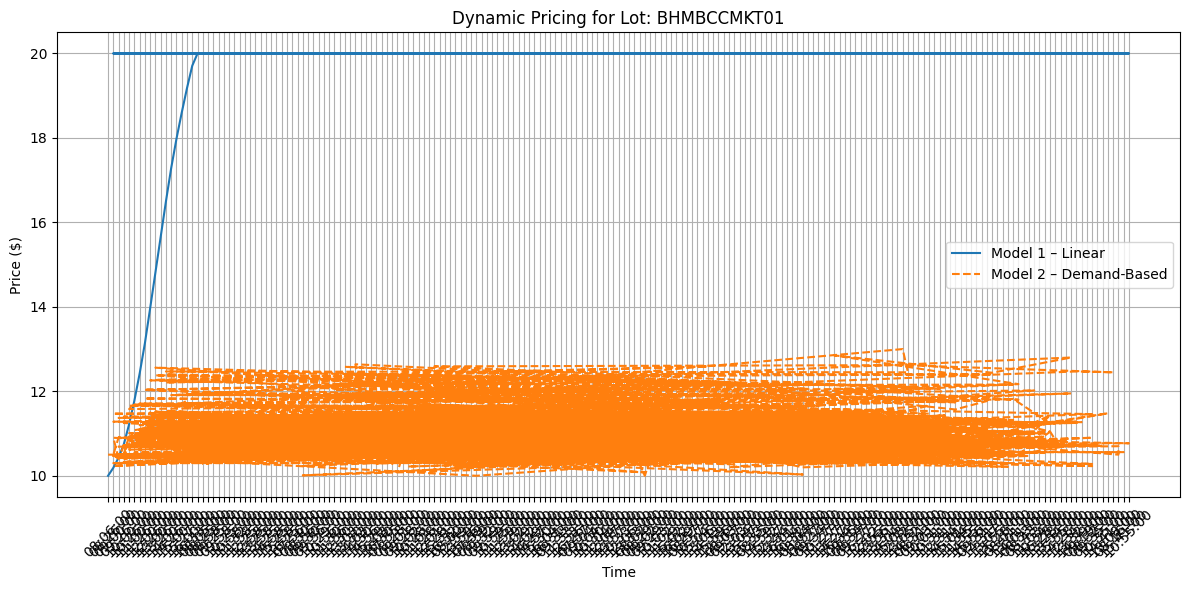

In [ ]:
import matplotlib.pyplot as plt

# Define lot_id
lot_id = lot_df['Location_ID'].iloc[0]

plt.figure(figsize=(12, 6))
plt.plot(lot_df['Time'], lot_df['Linear_Price'], label='Model 1 – Linear')
plt.plot(lot_df['Time'], lot_df['Demand_Price'], label='Model 2 – Demand-Based', linestyle='--')
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.title(f"Dynamic Pricing for Lot: {lot_id}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
!pip install bokeh


In [ ]:
import pandas as pd
from google.colab import files
import io

uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['dataset.csv']))
df.head()


Saving dataset.csv to dataset.csv


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [ ]:
df.rename(columns={
    'SystemCodeNumber': 'Location_ID',
    'VehicleType': 'Vehicle_Type',
    'TrafficConditionsNearby': 'Traffic',
    'LastUpdatedDate': 'Date',
    'LastUpdatedTime': 'Time'
}, inplace=True)

In [ ]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.io import push_notebook
import time

output_notebook()


In [ ]:
lot_df = df[df['Location_ID'] == df['Location_ID'].unique()[0]].copy()
lot_df = lot_df.sort_values(by=['Date', 'Time']).reset_index(drop=True)

from bokeh.layouts import column

source = ColumnDataSource(data=dict(x=[], y=[]))

p = figure(title="⏱️ Real-Time Parking Price", x_axis_label='Time', y_axis_label='Price ($)',
           width=800, height=400, x_range=[])

p.line(x='x', y='y', source=source, line_width=2, legend_label='Demand-Based Price', color='orange')
p.legend.location = 'top_left'

In [ ]:
def get_price(row, base_price=10):
    occ = row['Occupancy']
    cap = row['Capacity']
    queue = row['QueueLength']
    traffic = {'low': 0, 'medium': 1, 'high': 2}.get(row['TrafficConditionNearby'], 1)
    special = row['IsSpecialDay']
    vehicle = {'car': 1, 'bike': 0.5, 'truck': 1.5}.get(row['Vehicle_Type'], 1)

    demand = (1 * (occ / cap)) + (0.5 * queue) - (0.7 * traffic) + (2 * special) + vehicle
    norm_demand = (demand - 0.5) / (5.5 - 0.5)  # Normalize between 0–1
    price = base_price * (1 + 0.3 * norm_demand)
    return round(min(max(price, 5), 20), 2)

KeyboardInterrupt: 

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)


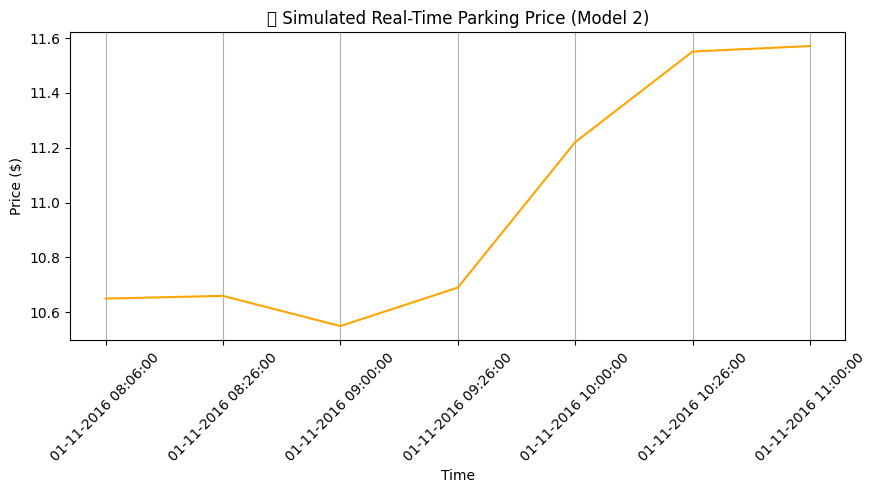

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

timestamps = []
prices = []

for i in range(len(lot_df)):
    row = lot_df.iloc[i]
    timestamp = f"{row['Date']} {row['Time']}"
    price = get_price(row)

    timestamps.append(timestamp)
    prices.append(price)

    clear_output(wait=True)
    plt.figure(figsize=(10, 4))
    plt.plot(timestamps, prices, color='orange', label='Demand-Based Price')
    plt.title("⏱️ Simulated Real-Time Parking Price (Model 2)")
    plt.xlabel("Time")
    plt.ylabel("Price ($)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    time.sleep(0.5)  # 50ms delay to simulate speed
